# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load modules
import cv2
import csv
import time
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import flatten

# TODO: Fill this in based on where you saved the training and testing data

training_file = './train.p'
testing_file = './test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(y_train)

# TODO: Number of testing examples.
n_test = len(y_test)

# TODO: What's the shape of an traffic sign image?
image_shape = image_shape = X_train.shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

img_size=X_train.shape[1] #Size of input images

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (39209, 32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

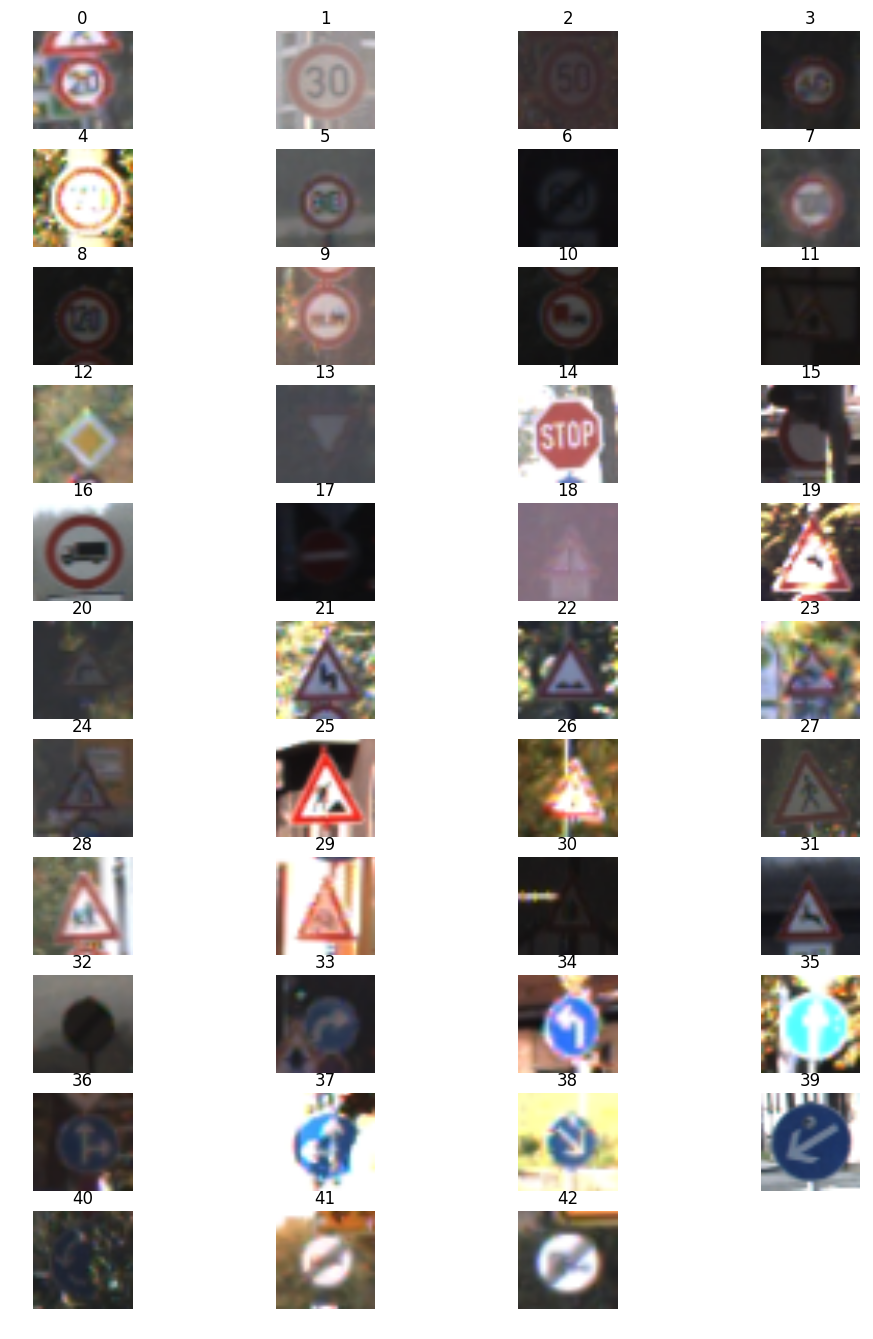

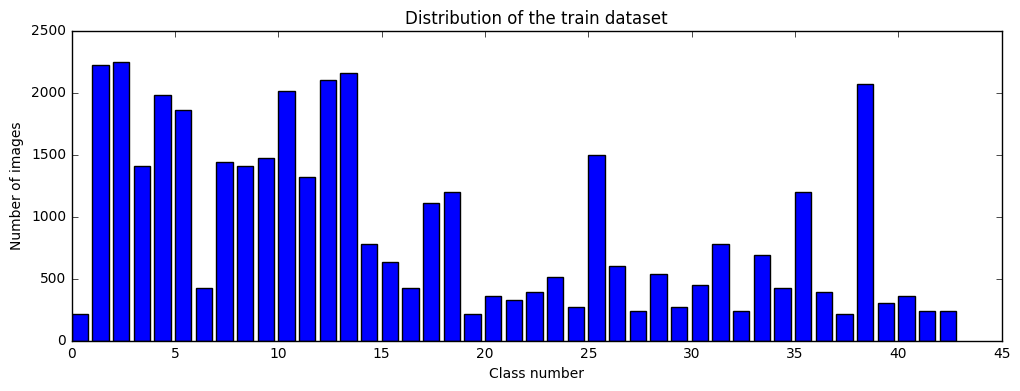

Min number of images per class = 210
Max number of images per class = 2250


In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
# Visualizations will be shown in the notebook.
%matplotlib inline

num_of_samples=[]
plt.figure(figsize=(12, 16.5))
for i in range(0, n_classes):
    plt.subplot(11, 4, i+1)
    x_selected = X_train[y_train == i]
    plt.imshow(x_selected[0, :, :, :]) #draw the first image of each class
    plt.title(i)
    plt.axis('off')
    num_of_samples.append(len(x_selected))
plt.show()

#Plot number of images per class
plt.figure(figsize=(12, 4))
plt.bar(range(0, n_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

print("Min number of images per class =", min(num_of_samples))
print("Max number of images per class =", max(num_of_samples))

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

#Data splitting
np.random.seed(seed=123) #Set seed for reproducability
#Size of the train subset
size_train = 0.8 #80% of the given dataset
size_train = int(size_train*n_train)
#Generate a mask and subsample training and validation da tasets
mask=np.random.permutation(np.arange(n_train))[:size_train]
X_train_sub, y_train_sub=X_train[mask], y_train[mask]
X_val, y_val = np.delete(X_train, mask,0), np.delete(y_train, mask,0)
n_train_sub = len(y_train_sub)
n_val = len(y_val)
print("Number of images in the train dataset = ", n_train_sub)
print("Number of images in the validation dataset = ", n_val)

Number of images in the train dataset =  31367
Number of images in the validation dataset =  7842


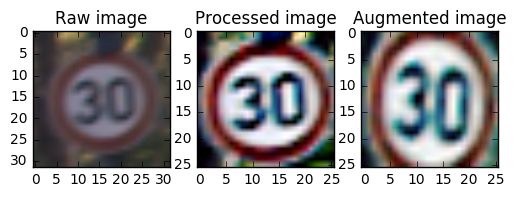

Final image size is (26, 26, 3)


In [5]:
#Some useful image functions
  
def show3img(img, img1, img2):
    plt.figure(figsize=(6, 2))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Raw image")
    plt.subplot(1, 3, 2)
    plt.imshow(img1)
    plt.title("Processed image")
    plt.subplot(1, 3, 3)
    plt.imshow(img2)
    plt.title("Augmented image")
    plt.show()
    
def eq_Hist(img):
    #Histogram Equalization
    img2=img.copy() 
    img2[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    img2[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    img2[:, :, 2] = cv2.equalizeHist(img[:, :, 2])
    return img2

def scale_img(img):
    img2=img.copy()
    sc_y=0.4*np.random.rand()+1.0
    img2=cv2.resize(img, None, fx=1, fy=sc_y, interpolation = cv2.INTER_CUBIC)
    c_x,c_y, sh = int(img2.shape[0]/2), int(img2.shape[1]/2), int(img_size/2)
    return img2

def crop(img, mar=0):
    c_x,c_y, sh = int(img.shape[0]/2), int(img.shape[1]/2), int(img_size/2-mar)
    return img[(c_x-sh):(c_x+sh),(c_y-sh):(c_y+sh)]

def rotate_img(img):
    c_x,c_y = int(img.shape[0]/2), int(img.shape[1]/2)
    ang = 30.0*np.random.rand()-15
    Mat = cv2.getRotationMatrix2D((c_x, c_y), ang, 1.0)
    return cv2.warpAffine(img, Mat, img.shape[:2])

def sharpen_img(img):
    gb = cv2.GaussianBlur(img, (5,5), 20.0)
    return cv2.addWeighted(img, 2, gb, -1, 0)
#Compute linear image transformation ing*s+m
def lin_img(img,s=1.0,m=0.0):
    img2=cv2.multiply(img, np.array([s]))
    return cv2.add(img2, np.array([m]))

#Change image contrast; s>1 - increase
def contr_img(img, s=1.0):
    m=127.0*(1.0-s)
    return lin_img(img, s, m)

def transform_img(img):
    img2=sharpen_img(img)
    img2=crop(img2,3)
    img2=contr_img(img2, 1.5)
    return eq_Hist(img2)

def augment_img(img):
    img=contr_img(img, 1.8*np.random.rand()+0.2)
    img=rotate_img(img)
    img=scale_img(img)
    return transform_img(img)

x_selected = X_train[y_train == 1]
im=x_selected[60, :, :, :]
imp=contr_img(im, 0.5)

show3img(im, transform_img(im), augment_img(im))
print("Final image size is", transform_img(im).shape)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

It is obvious that traffic signs on raw images do not cover images from edge to edge. So, cropping was applied (resulted in image resolution reduction from 32x32 px to 26x26 px). It is also beneficial for CNN training speed because we do not need to process some extra useless pixels. Images also demonstrate lack of sharpen, brightness and contrast, that is why sharpen with unsharp mask, contrast enhance and histogram equalization were applied. All operations are called in the __transform_img__ function.

Colors were saved (no grayscale conversion) because color can be the key to traffic sign classification (for example, sign background and edging colors). Some experiments on the same CNN architecture but with grayscale input images were conducted and shown worse results. It is in contrary to the Pierre Sermanet and Yann LeCun results.

In [6]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
X_train_aug = []
y_train_aug = []
X_val_prep = []

def create_data(n=10):
    for i in range(n_train_sub):
        img=X_train_sub[i]
        X_train_aug.append(transform_img(img))
        y_train_aug.append(y_train_sub[i])
        #Generate n new images out of each input image
        for j in range(n):
            X_train_aug.append(augment_img(img))
            y_train_aug.append(y_train_sub[i])       
    for i in range(n_val):
        img=X_val[i]
        X_val_prep.append(transform_img(img))
    print("Total number of images in the augmented dataset = ", len(X_train_aug))

create_data(10)

Total number of images in the augmented dataset =  345037


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

All images were processed by __transform_img__ function as discribed in the question 1. Training subset is 80% of initial train.p dataset randomly obtained, validation subset is the rest of the raw train dataset. For testing the full test.p dataset is used.

Training subset was also augmented by generating 10 extra images from every given image. Images were augmented by __augment_img__ function. The process consists of random contrast adjustment, rotation around image center (random value between -15 and 15 deg) and random vertical stretching (as the simplest way to simulate different viewing angle) by random value up to 40 %.

I decided to preserve distribution of signs between classes (see a chart above) as it can be expacted that it minics real-world distribution of signs and in case of unsertanty the CNN more likely will predict mome friquent traffic sign.

In [7]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

# Hyperparameters
mu = 0.0
sigma = 0.1
base_rate = 0.0005 #Base learning rate
dropout = 0.5 #dropout rate
rate = base_rate
def conv_layer(x, filter_w, in_d, out_d):
    conv_W = tf.Variable(tf.truncated_normal(shape=(filter_w, filter_w, in_d, out_d), mean = mu, stddev = sigma))
    conv_b = tf.Variable(tf.zeros(out_d))
    conv_res   = tf.nn.conv2d(x, conv_W, strides=[1, 1, 1, 1], padding='SAME') + conv_b
    return conv_res

def conv_relu_layer(x, filter_w, in_d, out_d):
    conv_W = tf.Variable(tf.truncated_normal(shape=(filter_w, filter_w, in_d, out_d), mean = mu, stddev = sigma))
    conv_b = tf.Variable(tf.zeros(out_d))
    conv_res   = tf.nn.conv2d(x, conv_W, strides=[1, 1, 1, 1], padding='SAME') + conv_b
    return tf.nn.relu(conv_res)

def maxpool_layer(x, filter_w):
    return tf.nn.max_pool(x,ksize=[1,filter_w,filter_w,1], strides=[1,1,1,1],padding='SAME')

def maxpool_stride_layer(x, filter_w, s):
    return tf.nn.max_pool(x,ksize=[1,filter_w,filter_w,1], strides=[1,s,s,1],padding='VALID')

def fc_layer(x, a, b):
    fc_W = tf.Variable(tf.truncated_normal(shape=(a, b), mean = mu, stddev = sigma))
    fc_b = tf.Variable(tf.zeros(b))
    fc = tf.matmul(x, fc_W) + fc_b
    return tf.nn.relu(fc)

#number of outputs on the first and the second inception modules
d_1 = 64
d_2 = 128
d_1x1 = 32

def inception_module(x, in_d, out_d):
    conv1x1 = conv_layer(x, 1, in_d, out_d)
    conv2 = conv_relu_layer(x, 1, in_d, d_1x1)
    conv3 = conv_relu_layer(x, 1, in_d, d_1x1)
    maxpool = maxpool_layer(x, 3)
    conv_maxpool = conv_layer(maxpool, 1, in_d, out_d)
    conv3x3 = conv_layer(conv2, 3, d_1x1, int(out_d/2))
    conv3x3 = conv_layer(conv3x3, 1, int(out_d/2), out_d)
    conv5x5 = conv_layer(conv3, 5, d_1x1, int(out_d/2))
    conv5x5 = conv_layer(conv5x5, 1, int(out_d/2), out_d)
    return tf.nn.relu(tf.concat(3, [conv1x1, conv3x3, conv5x5, conv_maxpool]))
    
def Net(x, out=43):    
    conv1 = conv_relu_layer(x, 1, 3, 3) #26x26x3
    conv2 = conv_relu_layer(conv1, 5, 3, 64) #26x26x32
    incept1 = inception_module(conv2, 64, d_1) #26x26x256
    maxpool1 = maxpool_stride_layer(incept1, 2, 2) #13x13x256
    incept2 = inception_module(maxpool1, d_1*4, d_2) #13x13x512
    maxpool2 = maxpool_stride_layer(incept2, 3, 2) #6x6x512
    conv3 = conv_layer(maxpool2, 1, 512, 256) #6x6x256
    fc0 = flatten(conv3)
    fc1 = fc_layer(fc0, 256*6*6, 512)
    fc1 = tf.nn.dropout(fc1, keep_prob)     
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(512, out), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(out))
    logits = tf.matmul(fc1, fc2_W) + fc2_b
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

The CNN architecture was inspired by [GoogLeNet] (https://www.cs.unc.edu/~wliu/papers/GoogLeNet.pdf). Color image with 26x26 px resolution is used as input, 43 neurons of the output layer represent all traffic sign classes. The CNN consists of two inception modules which are the same to ones from the GoogLeNet, but with two dimension reduction / dimension increase convolution 1x1 layers before and after 3x3 and 5x5 convolutions (for details see __inception_module__ function). The inception modules are alternating with maxpooling layers and are followed by a fc layer with 512 output neurons. The layer uses 50% dropout and experiments shown that it really help to decrease overfitting.

The architecture was created by a process of trial and error with the idea in mind to minimize computation cost while use inception modules.

In [8]:
### Train your model here.
### Feel free to use as many code cells as needed.

EPOCHS = 15
BATCH_SIZE = 128
x = tf.placeholder(tf.float32, (None, 26, 26, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)

logits = Net(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [9]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()

def evaluate(X_data, y_data, sess):
    num_examples = len(X_data)
    total_accuracy = 0
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [11]:
start_time = time.time()
with tf.Session() as sess:
    with open('./train_log_f.csv', 'wt') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(['Epoch','step','lr','loss','acc'])
        csvfile.flush()
        sess.run(tf.global_variables_initializer())
        num_examples = len(X_train_aug)
        print("Training...")
        for i in range(EPOCHS):
            print("EPOCH {} ".format(i+1))
            X_train_aug, y_train_aug,  = shuffle(X_train_aug, y_train_aug)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y= X_train_aug[offset:end], y_train_aug[offset:end]
                tr, loss = sess.run([training_operation, loss_operation], feed_dict={x: batch_x, y: batch_y,  keep_prob: dropout})
                if offset%102400==0:
                    acc = evaluate(X_val_prep,  y_val, sess)
                    print(offset, loss, acc)
                    writer.writerow([i+1, offset, rate, loss, acc])
                    csvfile.flush()
            print("Time :", time.time() - start_time)
            start_time = time.time()
            if (i+1)%5==0:
                rate=rate*0.8    
    saver.save(sess, './my_net_f.ckpt')
    print("Model saved")

Training...
EPOCH 1 
0 94.9943 0.0460341749554
102400 1.61739 0.633766896215
204800 1.04982 0.879112471339
307200 0.463036 0.933052792701
Time : 273.93615531921387
EPOCH 2 
0 0.86584 0.937515939978
102400 0.320135 0.954348380409
204800 0.33414 0.959576638628
307200 0.42072 0.963147156474
Time : 273.91756653785706
EPOCH 3 
0 0.250821 0.96735526665
102400 0.173637 0.965825044647
204800 0.245922 0.969523080984
307200 0.240286 0.970415710415
Time : 273.83959913253784
EPOCH 4 
0 0.169731 0.972711043101
102400 0.206027 0.973221117062
204800 0.301711 0.973731191023
307200 0.312598 0.975261412905
Time : 273.68194699287415
EPOCH 5 
0 0.12355 0.972966080082
102400 0.209485 0.974368783474
204800 0.201612 0.974113746493
307200 0.0644086 0.976536597807
Time : 273.55856943130493
EPOCH 6 
0 0.308347 0.973731191023
102400 0.103595 0.976154042336
204800 0.215202 0.976281560826
307200 0.202094 0.974751338944
Time : 273.4678227901459
EPOCH 7 
0 0.212652 0.976664116297
102400 0.25206 0.978066819689
204800

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

The CNN was trained with the Adam optimizer, batch size = 128 images, initial learning rate was 0.0005 with decrease by 20% every 5 epochs. The model was trained for 15 epochs (345037 images in each epoch) with one dataset.

Variables were initialized with using of a truncated normal distribution with mu = 0.0 and sigma = 0.1. Learning rate was finetuned by try and error process.

Traffic sign classes were coded into one-hot encodings.

 Detailed training log can be found in the *train_log_f.csv* file (it includes minibatch loss and accuracy). As one can observe, at the end of the training process, accuracy stopped increasing and loss oscillated around relatively small value.

Training was performed on a GTX 1070 GPU and it takes about one hour. 

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**


It was a trial and error process, but all steps were inspired by scientific papers, by GoogLeNet approach, particularly.

As it is an image classification problem, convolutional layers were used as it is common in modern image classification systems as reduce computation (as compared to classical neural network with only fc layers). It seems to me that inception moduls are essential for good performance on such kind of tasks as they allow to do not select optimal layer (say, convolution 5x5 or 3x3), by perform different layer types simultaneously and it selects the best one on its own.

In [18]:
#Prepare testing dataset
X_test_prep=[]
for i in range(n_test):
    img=X_test[i]
    X_test_prep.append(transform_img(img))

#Run testing
with tf.Session() as sess:
    saver.restore(sess, './my_net_f.ckpt')
    test_accuracy = evaluate(X_test_prep, y_test, sess)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.950


So, we have a not bad (95%) results on the testing dataset!

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

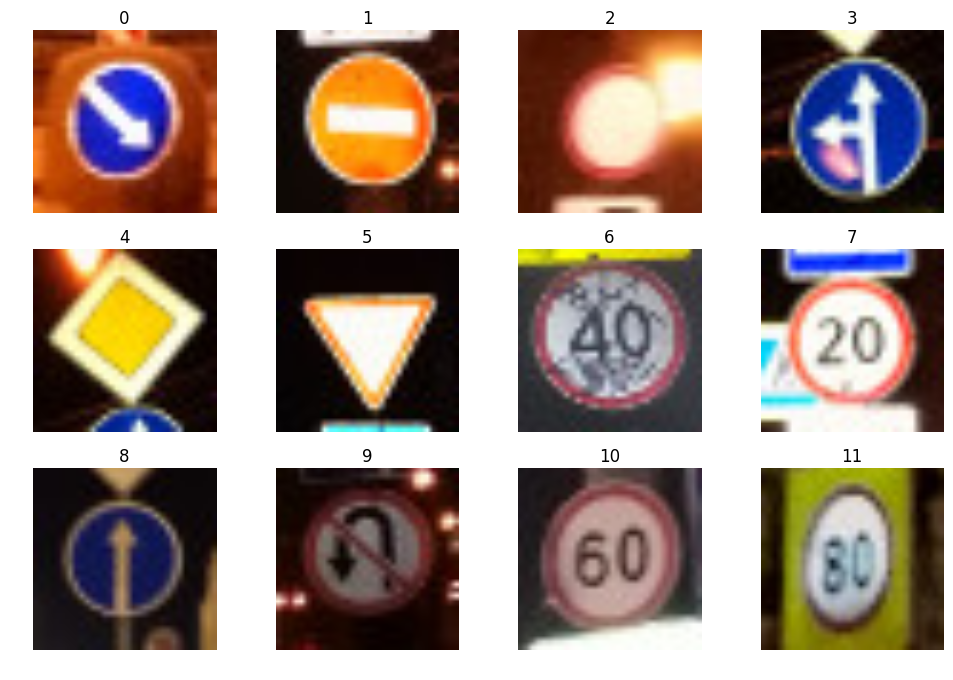

In [19]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

#Import traffic signs class names
signs_class=[]
with open('signnames.csv', 'rt') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=',')
    for row in reader:
        signs_class.append((row['SignName']))

#Import test images  
test_img_paths = [img_path for img_path in glob.glob("./new_images/*")]
test_img=np.uint8(np.zeros((12,32,32,3)))
for i, imp in enumerate(test_img_paths):
    img=cv2.imread(imp, cv2.IMREAD_COLOR)
    b,g,r = cv2.split(img)
    img = cv2.merge([r,g,b])
    test_img[i]=img

#Visualize new raw images
plt.figure(figsize=(12, 8))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(test_img[i]) 
    plt.title(i)
    plt.axis('off')
    num_of_samples.append(len(x_selected))
plt.show()

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

There are 10 real traffic signs from Moscow streets correspond to presented in the train dataset classes. They have a little bit different to the test dataset colors and arrows style. The also was taken at night with a flashlight, so, background and signs brightness can be challenging. Some traffic signs are dirty or images are light damaged.

There are 2 additional road signs missing in the training dataset ( "No U-turn" and "speed limit (40 km / h)"). They should not be used to assess the accuracy, but included as experiment.

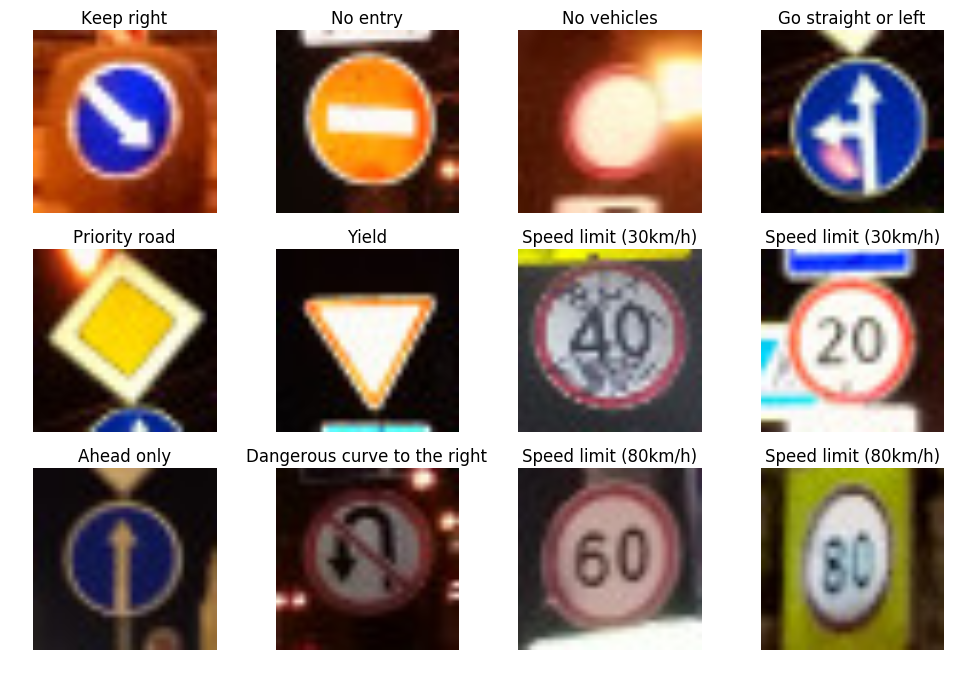

In [30]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
def test_net(X_data, sess):
    pred_sign = sess.run(tf.argmax(logits, 1), feed_dict={x: X_data, keep_prob: 1.0})
    return pred_sign

X_test_data=np.uint8(np.zeros((12,26,26,3)))
for i in range(12):
    img=test_img[i]
    X_test_data[i]=transform_img(img)

X_test_data = X_test_data.reshape((-1, 26, 26, 3)).astype(np.float32)
    
with tf.Session() as sess:
    saver.restore(sess, './my_net_f.ckpt')
    signs_classes=test_net(X_test_data, sess)


plt.figure(figsize=(12, 8))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(test_img[i]) 
    plt.title(signs_class[signs_classes[i]])
    plt.axis('off')
plt.show()

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

We can see that 2 of traffic signs of presented in the training set classes were misclassified ("speed limit (20 km / h)" and "speed limit (60 km / h)"). In both cases net correctly respond that they were a speed limit signs, so only numbers were recognized incorrectly. (One of the possible solution for real world application is to train another NN to classify numbers only). So, accuracy is about 80% on the real world extra images.

Extra sign "speed limit (40 km / h)" was misclassified (obviously) as a another speed limit sign, so, the CNN can understand traffic sign types quite well. 

In [47]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

def test_net(X_data, sess): 
    prob = sess.run(tf.nn.softmax(logits), feed_dict={x: X_data, keep_prob: 1.0})    
    top_5 = tf.nn.top_k(prob, k=5)
    return sess.run(top_5)


with tf.Session() as sess:
    saver.restore(sess, './my_net_f.ckpt')
    signs_top_5=test_net(X_test_data, sess)

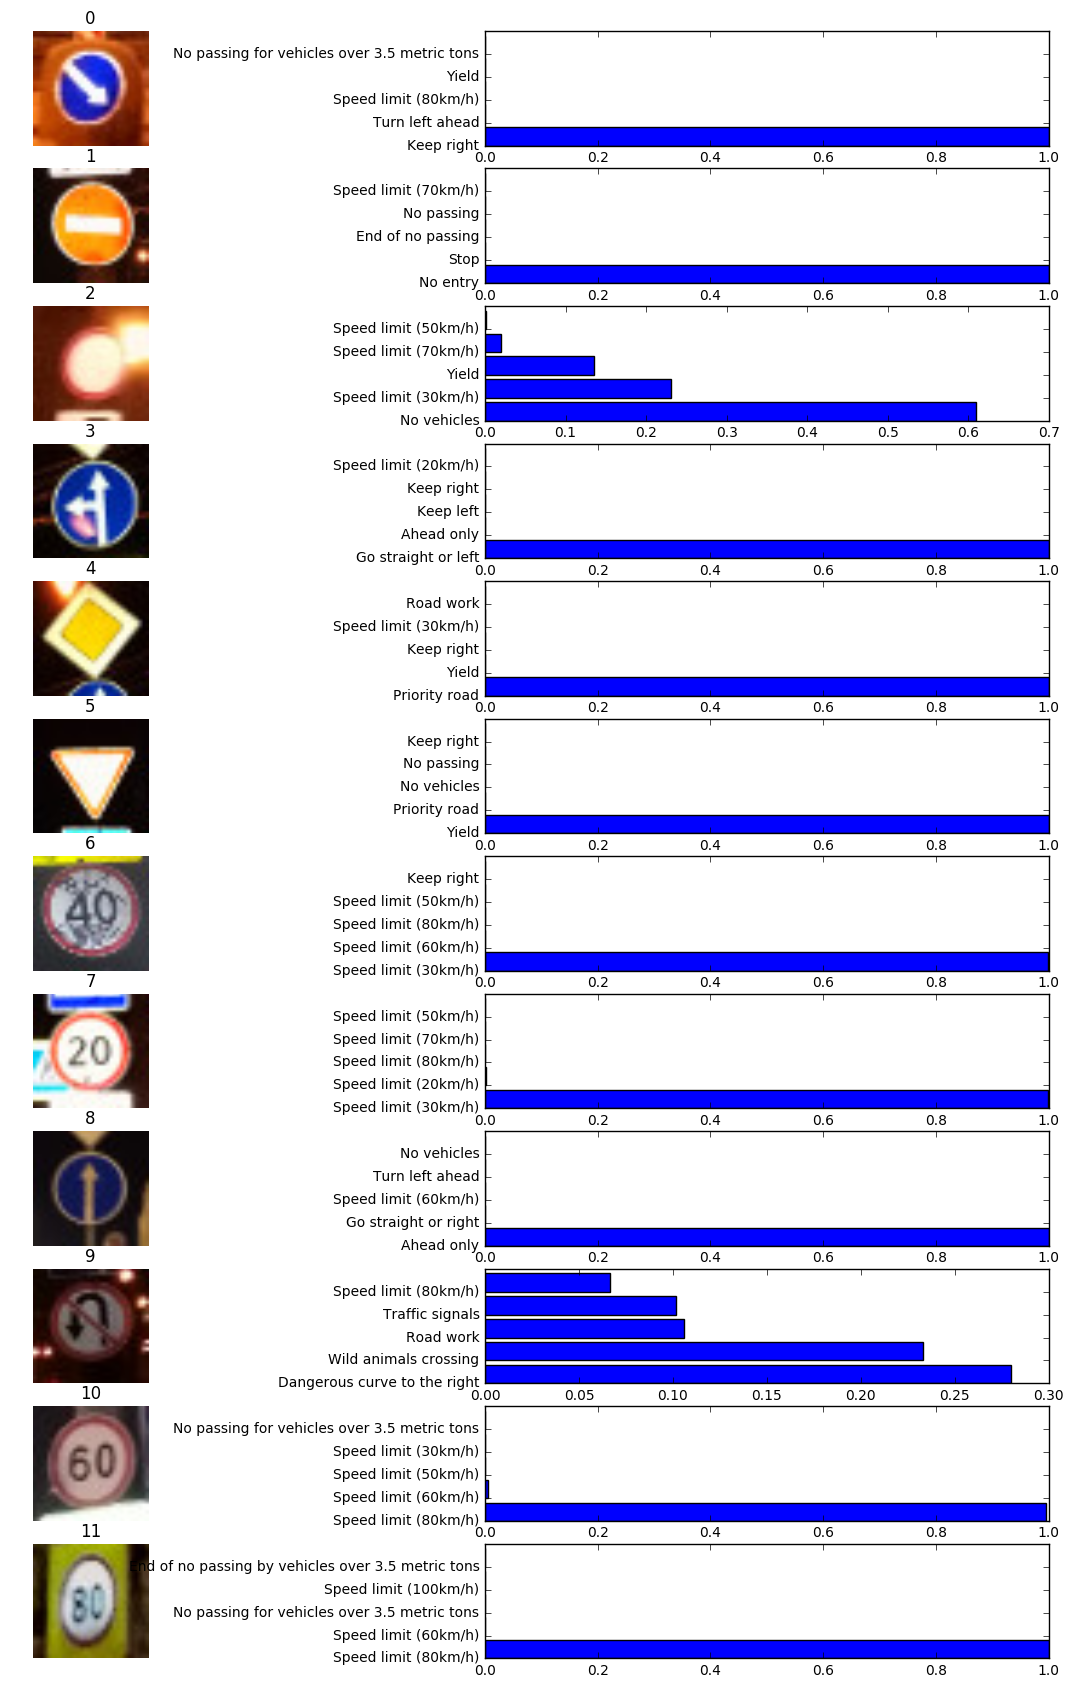

In [49]:
plt.figure(figsize=(16, 21))
for i in range(12):
    plt.subplot(12, 2, 2*i+1)
    plt.imshow(test_img[i]) 
    plt.title(i)
    plt.axis('off')
    plt.subplot(12, 2, 2*i+2)
    plt.barh(np.arange(1, 6, 1), signs_top_5.values[i, :])
    labs=[signs_class[j] for j in signs_top_5.indices[i]]
    plt.yticks(np.arange(1, 6, 1), labs)
plt.show()

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

In all cases except the extra sign "No U-turn" the predictor was very certain. In case of misclassified speed limit signs the correct predictions were the second probable option. "No vehicles" presented some difficulties as it has a big hotspot, but was classified correctly. So, the system is quite reliable and with some modifications it could perform really well on real data.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.